In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers  import Concatenate
from tensorflow.keras.layers import AveragePooling2D, Dropout, Input, BatchNormalization, Flatten
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from tqdm import tqdm
import urllib
from tensorflow.keras.preprocessing import image
from sklearn.metrics import precision_recall_curve,roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import os
from sklearn.metrics import log_loss, brier_score_loss
from sklearn.metrics import cohen_kappa_score
import matplotlib.cm as cm
from sklearn.metrics import matthews_corrcoef
import pandas as pd
import seaborn as sns
import numpy as np
import cv2
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score
from tensorflow.keras.utils import to_categorical
%matplotlib inline

In [2]:
image_path="../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/"

In [3]:
train_image_path="../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/"
valid_image_path="../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/"
test_image_path="../input/new-plant-diseases-dataset/test/"

In [4]:
class_names = os.listdir(image_path)
print(class_names)

['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Apple___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', 'Tomato___Leaf_Mold', 'Tomato__

In [5]:
numberof_images={}
for class_name in class_names:
    numberof_images[class_name]=len(os.listdir(image_path+"/"+class_name))
images_each_class=pd.DataFrame(numberof_images.values(),index=numberof_images.keys(),columns=["Number of images"])
images_each_class

,Number of images
Tomato___Late_blight,1851
Tomato___healthy,1926
Grape___healthy,1692
Orange___Haunglongbing_(Citrus_greening),2010
Soybean___healthy,2022
Squash___Powdery_mildew,1736
Potato___healthy,1824
Corn_(maize)___Northern_Leaf_Blight,1908
Tomato___Early_blight,1920
Tomato___Septoria_leaf_spot,1745


In [6]:
batch_size=32

In [7]:
traindata_generator=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,zoom_range=0.2,width_shift_range=0.2,height_shift_range=0.2,
                                                                    shear_range=0.2, horizontal_flip=True,validation_split=0.2)

validdata_generator=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
testdata_generator=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [8]:
train_data_generator=traindata_generator.flow_from_directory(train_image_path,batch_size=batch_size,class_mode="categorical",
                                                           target_size=(120,120),color_mode="rgb",shuffle=True )

Found 70295 images belonging to 38 classes.


In [9]:
valid_data_generator=validdata_generator.flow_from_directory(train_image_path,batch_size=batch_size,class_mode="categorical",
                                                           target_size=(120,120),color_mode="rgb",shuffle=True )

Found 70295 images belonging to 38 classes.


In [10]:
test_data_generator=testdata_generator.flow_from_directory(valid_image_path,batch_size=batch_size,class_mode="categorical",
                                                           target_size=(120,120),color_mode="rgb",shuffle=False )

Found 17572 images belonging to 38 classes.


In [11]:
train_number=train_data_generator.samples
valid_number=valid_data_generator.samples

In [12]:
def inceptionnet(x,filters):
    
    #(1x1) layer
    layer1=Conv2D(filters=filters[0],kernel_size=(1,1),strides=1,padding="same",activation="relu")(x)
    
    #(3x3) layer
    layer2=Conv2D(filters=filters[1][0],kernel_size=(1,1),strides=1,padding="same",activation="relu")(x)
    

    layer2=Conv2D(filters=filters[1][1],kernel_size=(1,1),strides=1,padding="same",activation="relu")(layer2)
    
    #(5x5) layer
    
    layer3=Conv2D(filters=filters[2][0],kernel_size=(5,5),strides=1,padding="same",activation="relu")(x)
    
    layers=Conv2D(filters=filters[2][1],kernel_size=(5,5),strides=1,padding="same",activation="relu")(layer3)
    
    
    
    layer4=MaxPooling2D(pool_size=(3,3),strides=1,padding="same")(x)
    layer4=Conv2D(filters=filters[3],kernel_size=(1,1),strides=1,padding="same",activation="relu")(layer4)
    
    
    return Concatenate(axis=-1)([layer1,layer2,layer3,layer4])
    
    
def helperfunction(x,name=None):
    
    layer=AveragePooling2D(pool_size=(5,5),strides=3,padding="valid")(x)
    
    layer=Conv2D(filters=128,kernel_size=(1,1),strides=1,padding="same",activation="relu")(layer)
    
    layer=Flatten()(layer)
    
    layer=Dense(units=255,activation="relu")(layer)
    
    layer=Dropout(0.5)(layer)
    layer=Dense(units=38,activation="softmax",name=name)(layer)
    
    return layer
    
       
def googlenet():
    
    #taking layer input
    inputlayer=Input(shape=(120,120,3))
    
    #layer_1
    layer=Conv2D(filters=64,kernel_size=(7,7),strides=1,padding="same",activation="relu")(inputlayer)
    
    layer=MaxPooling2D(pool_size=(3,3),strides=2,padding="same")(layer)
    
    layer=BatchNormalization()(layer)
    
    #layer_2
    layer=Conv2D(filters=64,kernel_size=(1,1),strides=1,padding="same",activation="relu")(layer)
    
    layer=Conv2D(filters=192,kernel_size=(3,3),strides=1,padding="same",activation="relu")(layer)
    
    layer=BatchNormalization()(layer)
    layer=MaxPooling2D(pool_size=(3,3),strides=2,padding="same")(layer)
    
    #layer_3
    layer=inceptionnet(layer,[64,(96,128),(16,32),32])
    layer=inceptionnet(layer,[128,(128,192),(32,96),64])
    layer=MaxPooling2D(pool_size=(3,3),strides=2,padding="same")(layer)
    
    #layer_4
    layer=inceptionnet(layer,[192,(96,208),(16,48),64])
    final_0=helperfunction(layer,name="final_layer_0")
    
    layer=inceptionnet(layer,[160,(112,224),(24,64),64])
    layer=inceptionnet(layer,[128,(128,256),(24,64),64])
    layer=inceptionnet(layer,[112,(144,288),(32,64),64])
    final_1=helperfunction(layer,name="final_layer_1")
    
    layer=inceptionnet(layer,[256,(160,320),(32,128),128])
    layer=MaxPooling2D(pool_size=(3,3),strides=2,padding="same")(layer)
    
    
    #layer_5
    layer=inceptionnet(layer,[256,(160,320),(32,128),128])
    layer=inceptionnet(layer,[384,(192,384),(48,128),128])
    layer=AveragePooling2D(pool_size=(7,7),strides=1,padding="same")(layer)
    
    #layer_6
    
    layer=Flatten()(layer)
    layer=Dropout(0.5)(layer)
    layer=Dense(units=256,activation="linear")(layer)
    final_2=Dense(units=38,activation="softmax",name="final_layer_2")(layer)
    
    
    model=Model(inputs=inputlayer,outputs=[final_2,final_0,final_1])
    
    return model

In [13]:
model=googlenet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 120, 120, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 60, 60, 64)   0           ['conv2d[0][0]']                 
                                                                                              

In [14]:
learning_rate = 0.001

opti = Adam(learning_rate=learning_rate)

model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], loss_weights=[1, 0.3, 0.3], optimizer=opti, metrics=['accuracy'])

In [16]:
from tensorflow.keras import callbacks
early_stopping_cb = callbacks.EarlyStopping(monitor="val_loss", patience=3)
reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                              factor=0.2, 
                                              patience=2,
                                              verbose=1, 
                                              min_lr=1e-7)

checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_weights_only=True,
                                                      save_best_only=True,
                                                      monitor="val_loss")

history = model.fit(train_data_generator,
                    steps_per_epoch=train_number // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[early_stopping_cb, model_checkpoint, reduce_lr],
                    validation_data = valid_data_generator, 
                    validation_steps=valid_number // batch_size,
                    # steps_per_epoch = 20,
                    # validation_steps = 20
                    )


Epoch 1/30
2196/2196 [==============================] - 508s 231ms/step - loss: 0.3943 - final_layer_2_loss: 0.2442 - final_layer_0_loss: 0.2460 - final_layer_1_loss: 0.2545 - final_layer_2_accuracy: 0.9270 - final_layer_0_accuracy: 0.9246 - final_layer_1_accuracy: 0.9224 - val_loss: 0.6410 - val_final_layer_2_loss: 0.4020 - val_final_layer_0_loss: 0.4132 - val_final_layer_1_loss: 0.3837 - val_final_layer_2_accuracy: 0.8871 - val_final_layer_0_accuracy: 0.8929 - val_final_layer_1_accuracy: 0.8995 - lr: 0.0010
Epoch 2/30
2196/2196 [==============================] - 504s 229ms/step - loss: 0.3422 - final_layer_2_loss: 0.2115 - final_layer_0_loss: 0.2152 - final_layer_1_loss: 0.2205 - final_layer_2_accuracy: 0.9362 - final_layer_0_accuracy: 0.9351 - final_layer_1_accuracy: 0.9336 - val_loss: 1.2168 - val_final_layer_2_loss: 0.6560 - val_final_layer_0_loss: 1.2082 - val_final_layer_1_loss: 0.6612 - val_final_layer_2_accuracy: 0.8379 - val_final_layer_0_accuracy: 0.8127 - val_final_layer_1_

In [ ]:
model.save("model.h5")
from tensorflow.keras.models import load_model

model = load_model("model.h5")

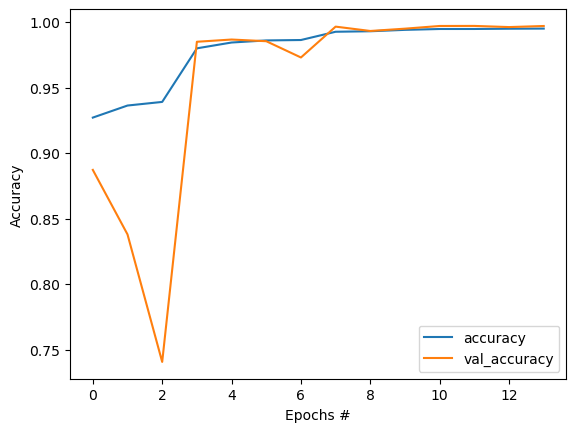

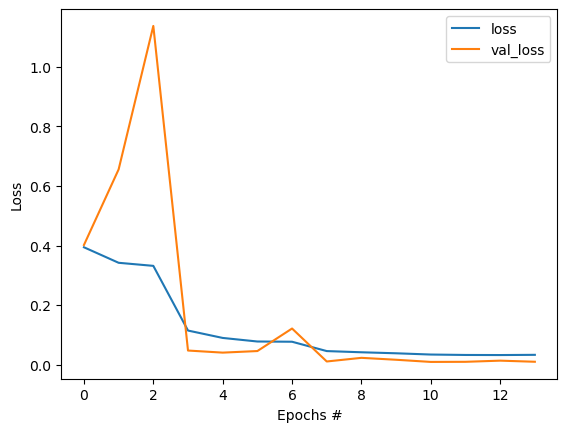

In [28]:
# Plotting
hist = history.history
def show_plt(type):
    if type == 1:
        plt.plot(hist["final_layer_2_accuracy"], label="accuracy")
        plt.plot(hist["val_final_layer_2_accuracy"], label="val_accuracy")
        plt.ylabel("Accuracy")
        plt.xlabel("Epochs #")
        plt.legend()
        plt.show()
    else:
        plt.plot(hist["loss"], label="loss")
        plt.plot(hist["val_final_layer_2_loss"], label="val_loss")
        plt.ylabel("Loss")
        plt.xlabel("Epochs #")
        plt.legend()
        plt.show()
        
show_plt(1)
show_plt(0)

In [17]:
pred, _, _=model.predict(test_data_generator)
final_predict = np.argmax(pred,axis=1)
true_data=test_data_generator.classes

550/550 [==============================] - 118s 214ms/step


In [18]:

acc_score = accuracy_score(true_data,final_predict)
print(f'Accuracy Score: {acc_score:.4f}')

Accuracy Score: 0.9933


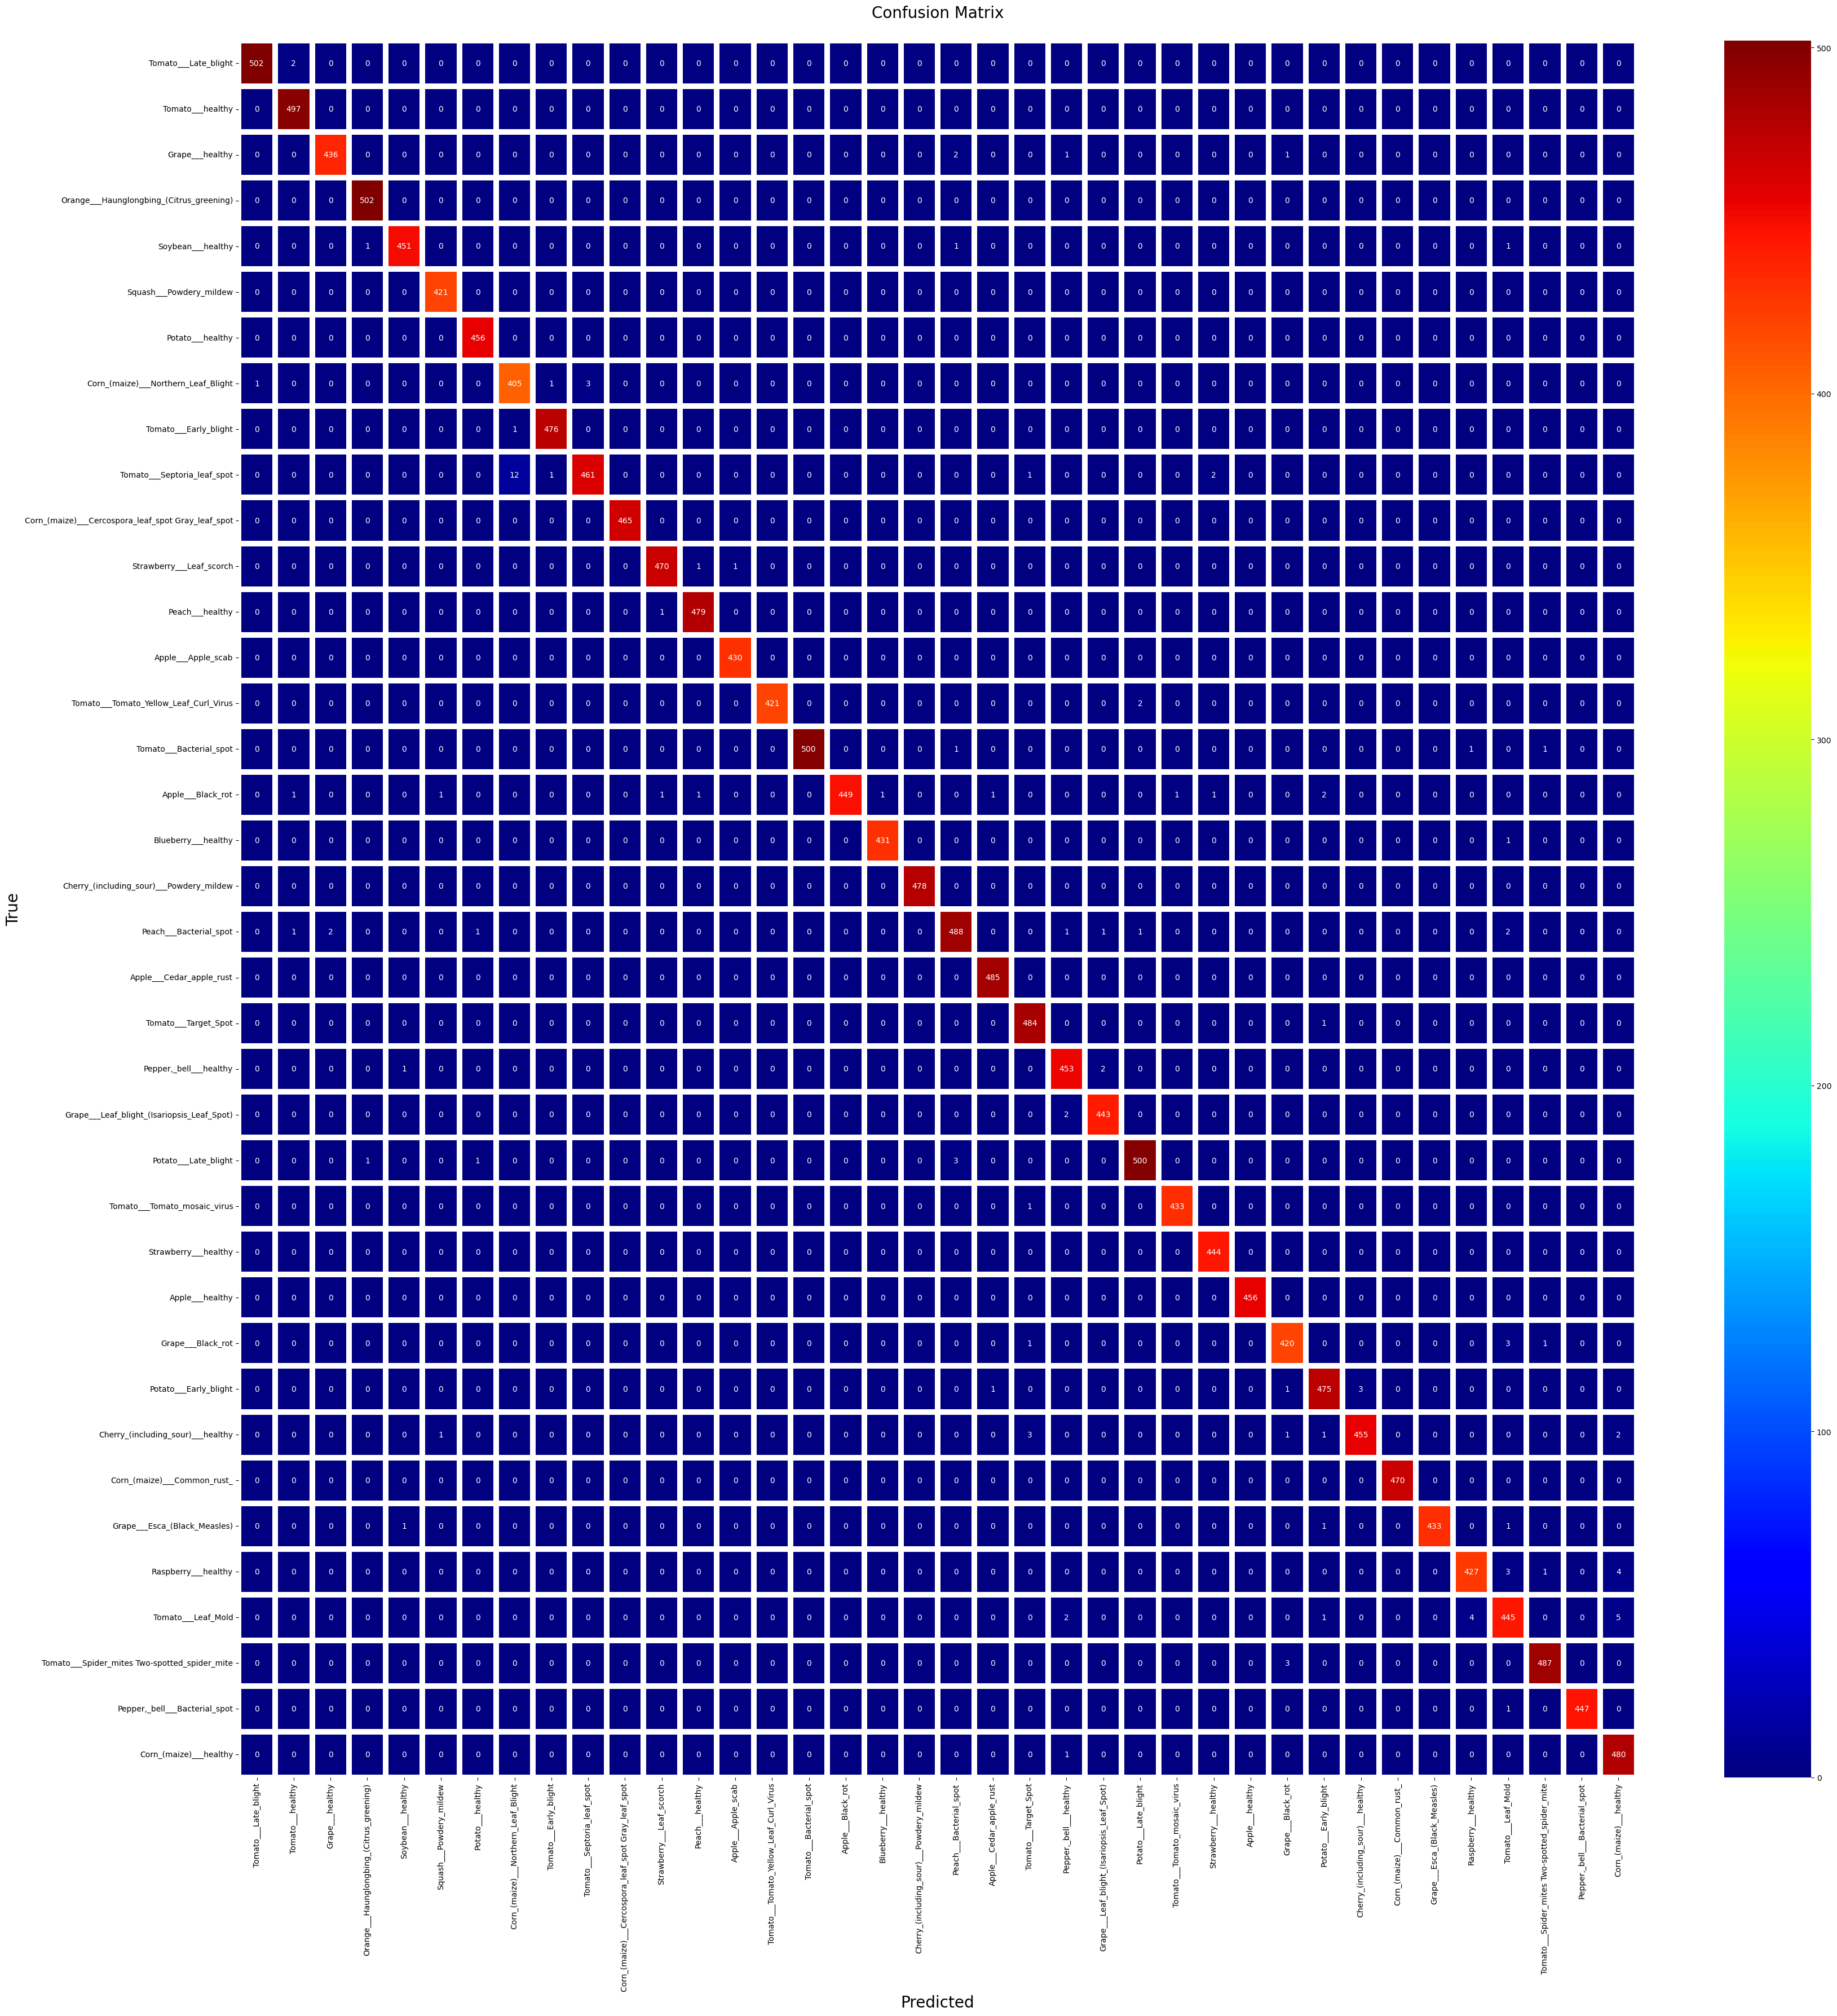

In [21]:
plt.figure(figsize=(40,40))
confusion = confusion_matrix(true_data, final_predict)
sns.heatmap(confusion, annot=True, fmt='d', cmap='jet',xticklabels=class_names,
            yticklabels=class_names,lw=6)
plt.xlabel('Predicted',fontsize=20,color="black")
plt.ylabel('True',fontsize=20,color="black")
plt.title('Confusion Matrix\n',fontsize=20,color="black")
plt.show()

In [22]:
print(classification_report(true_data, final_predict,target_names=class_names))

                                                    precision    recall  f1-score   support

                              Tomato___Late_blight       1.00      1.00      1.00       504
                                  Tomato___healthy       0.99      1.00      1.00       497
                                   Grape___healthy       1.00      0.99      0.99       440
          Orange___Haunglongbing_(Citrus_greening)       1.00      1.00      1.00       502
                                 Soybean___healthy       1.00      0.99      0.99       454
                           Squash___Powdery_mildew       1.00      1.00      1.00       421
                                  Potato___healthy       1.00      1.00      1.00       456
               Corn_(maize)___Northern_Leaf_Blight       0.97      0.99      0.98       410
                             Tomato___Early_blight       1.00      1.00      1.00       477
                       Tomato___Septoria_leaf_spot       0.99      0.97      0.

1/1 [==============================] - 0s 23ms/step
Predicted class: Strawberry___healthy
Maximum probability: 0.4733975827693939


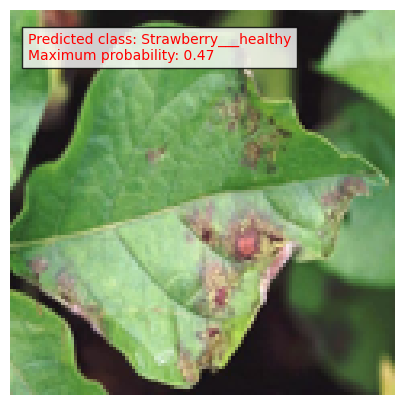

In [29]:
plt.figure(figsize=(5, 5))

img_url = "https://cdn.britannica.com/89/126689-004-D622CD2F/Potato-leaf-blight.jpg"

filename, headers = urllib.request.urlretrieve(img_url)
img_path = os.path.join(os.getcwd(), filename)
img = Image.open(img_path)
img = img.resize((120, 120))
img = np.array(img) / 255.0
img = np.expand_dims(img, axis=0)
probs = model.predict(img)[0]

# Get the predicted class index and name
pred_class_prob = np.argmax(probs)
pred_class_name = class_names[pred_class_prob]

max_prob = np.max(probs)
print(f'Predicted class: {pred_class_name}')
print(f'Maximum probability: {max_prob}')

# Display the image with the predicted class and probability
plt.imshow(img[0])
plt.axis('off')
plt.text(5, 15, f'Predicted class: {pred_class_name}\nMaximum probability: {max_prob:.2f}', fontsize=10, color='red', bbox=dict(facecolor='white', alpha=0.8))
plt.show()